# **Satelite Coordinates Classification**

In [ ]:
import numpy as np
import h5py
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/My Drive/datasets/earth_data.zip" -d "./"
!ls

Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/datasets/earth_data.zip
  inflating: ./earth_data.h5         
earth_data.h5  gdrive  sample_data


In [ ]:
def loadDataH5():
    with h5py.File('earth_data.h5', 'r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print(trainX.shape, trainY.shape)
        print(valX.shape, valY.shape)
    return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


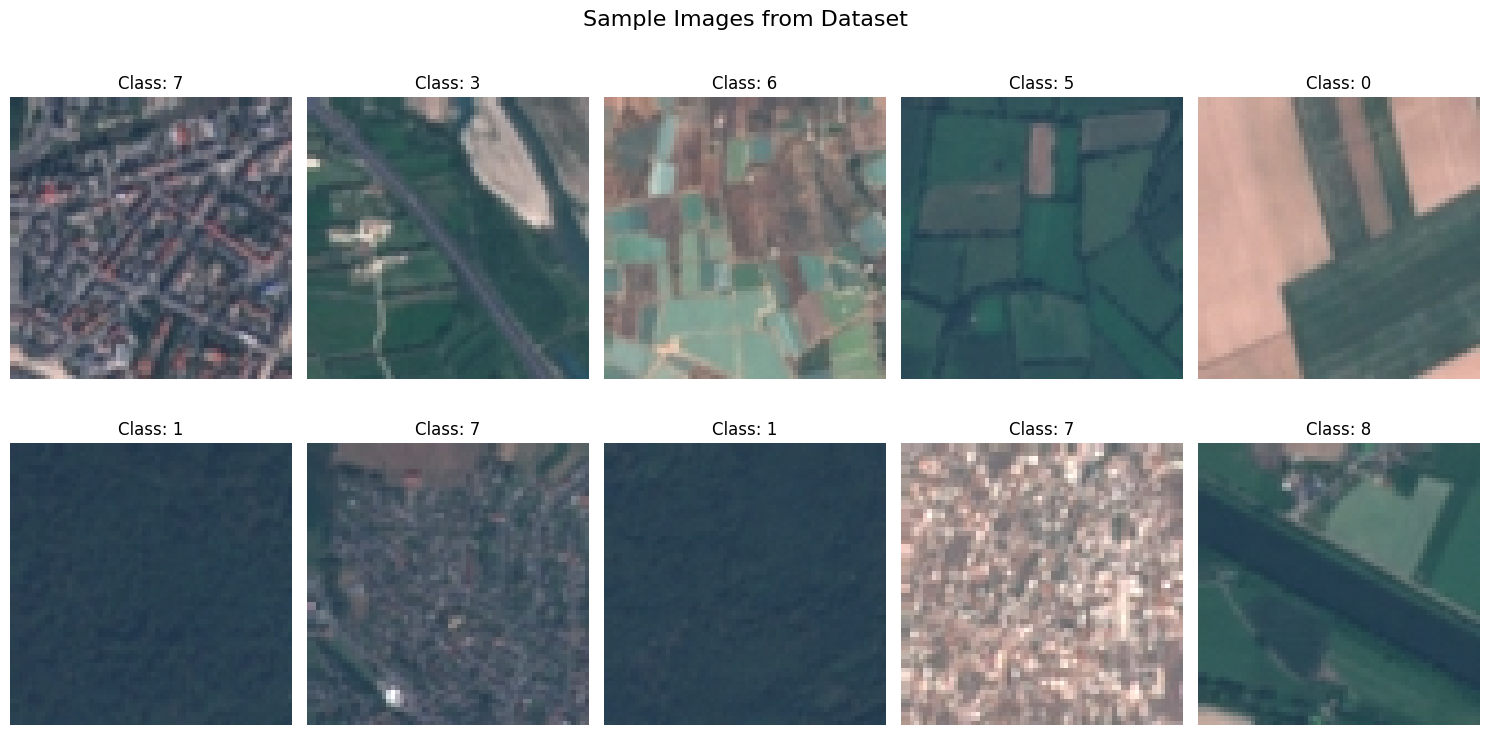

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(trainX[i])
    plt.title(f'Class: {trainY[i]}')
    plt.axis('off')
plt.suptitle('Sample Images from Dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
trainX = preprocess_input(trainX.astype(np.float32))
valX = preprocess_input(valX.astype(np.float32))

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
x = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
train_features = feature_extractor.predict(trainX, batch_size=64, verbose=1)
val_features = feature_extractor.predict(valX, batch_size=64, verbose=1)

300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


In [ ]:
def evaluate_model(model, name):
    model.fit(train_features, trainY)
    preds = model.predict(val_features)
    acc = accuracy_score(valY, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(valY, preds))
    return acc

In [ ]:
# Logistic Regression
acc_log = evaluate_model(LogisticRegression(), "Logistic Regression")

# Random Forest
acc_rf = evaluate_model(RandomForestClassifier(), "Random Forest")

# Support Vector Machine
acc_svm = evaluate_model(SVC(), "SVM")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Accuracy: 0.9065
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       600
           1       0.96      0.97      0.97       600
           2       0.92      0.89      0.90       600
           3       0.81      0.84      0.83       500
           4       0.95      0.93      0.94       500
           5       0.88      0.91      0.89       400
           6       0.84      0.87      0.86       500
           7       0.96      0.95      0.96       600
           8       0.87      0.85      0.86       500

    accuracy                           0.91      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.91      0.91      0.91      4800


Random Forest Accuracy: 0.8929
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       600
           1       0.95      0.97      0.96       600
           2       0.88      0.93      0.90       600
        

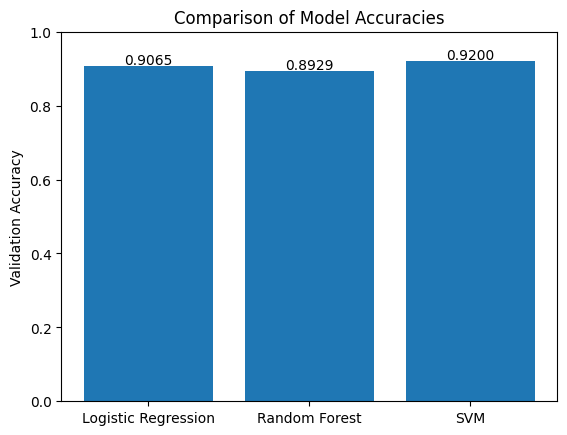

In [ ]:
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [acc_log, acc_rf, acc_svm]

plt.figure()
plt.bar(models, accuracies)
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Model Accuracies')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.ylim(0, 1.0)
plt.show()

### **Results**
The SVM gave the best solutions, followed by the LR and at last RF.

In [ ]:
import h5py
import time
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

num_classes = len(np.unique(trainY))

I will use the following callbacks so that I can fine-tune the models until they are fit.

In [ ]:
# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

### **MODEL 1: Unfrezing last layer**
For this model i unfreze and fit only the last layer so that it can keep its main structure and only modify the defining features.

I also use a dropout layer to make the result more robust.

In [ ]:
def build_model_unfreeze_block(block_to_unfreeze=5):
    base = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))
    for layer in base.layers:
        if f'block{block_to_unfreeze}_' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    return model

model1 = build_model_unfreeze_block(block_to_unfreeze=5)
model1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

start = time.time()
history1 = model1.fit(
    trainX, trainY,
    validation_data=(valX,valY),
    epochs=15, batch_size=64,
    callbacks=[reduce_lr, early_stop],
    verbose=2
)
print("Variant 1 training time:", time.time() - start)


Epoch 1/15
300/300 - 27s - 89ms/step - accuracy: 0.8254 - loss: 0.6075 - val_accuracy: 0.9240 - val_loss: 0.2353 - learning_rate: 1.0000e-04
Epoch 2/15
300/300 - 37s - 124ms/step - accuracy: 0.9371 - loss: 0.1962 - val_accuracy: 0.9379 - val_loss: 0.1919 - learning_rate: 1.0000e-04
Epoch 3/15
300/300 - 38s - 128ms/step - accuracy: 0.9621 - loss: 0.1172 - val_accuracy: 0.9533 - val_loss: 0.1682 - learning_rate: 1.0000e-04
Epoch 4/15
300/300 - 19s - 63ms/step - accuracy: 0.9729 - loss: 0.0826 - val_accuracy: 0.9496 - val_loss: 0.2125 - learning_rate: 1.0000e-04
Epoch 5/15
300/300 - 18s - 62ms/step - accuracy: 0.9817 - loss: 0.0538 - val_accuracy: 0.9477 - val_loss: 0.1936 - learning_rate: 1.0000e-04
Epoch 6/15

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
300/300 - 23s - 75ms/step - accuracy: 0.9833 - loss: 0.0496 - val_accuracy: 0.9494 - val_loss: 0.2067 - learning_rate: 1.0000e-04
Epoch 7/15
300/300 - 39s - 129ms/step - accuracy: 0.9948 - loss: 0.0155 - v

### **MODEL 2: Unfrezing last 2 layers and adding Batch Normalization**
Same as before but unfrezing another layer so that it can fine tune a bit more, and in order to help the model go a bit faster as now it needs to process a lot more stuff, i will use a Batch Normalization layer too and increase the dropout a bit.

In [ ]:
def build_model_unfreeze_blocks(blocks=[4,5]):
    base = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))
    for layer in base.layers:
        layer.trainable = any(f'block{b}_' in layer.name for b in blocks)

    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base.input, outputs=out)

model2 = build_model_unfreeze_blocks([4,5])
model2.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

start = time.time()
history2 = model2.fit(
    trainX, trainY,
    validation_data=(valX,valY),
    epochs=20, batch_size=64,
    callbacks=[reduce_lr, early_stop],
    verbose=2
)
print("Variant 2 training time:", time.time() - start)


Epoch 1/20
300/300 - 34s - 112ms/step - accuracy: 0.8499 - loss: 0.4663 - val_accuracy: 0.9177 - val_loss: 0.2629 - learning_rate: 5.0000e-05
Epoch 2/20
300/300 - 27s - 90ms/step - accuracy: 0.9509 - loss: 0.1511 - val_accuracy: 0.9438 - val_loss: 0.1786 - learning_rate: 5.0000e-05
Epoch 3/20
300/300 - 41s - 136ms/step - accuracy: 0.9680 - loss: 0.0977 - val_accuracy: 0.9581 - val_loss: 0.1291 - learning_rate: 5.0000e-05
Epoch 4/20
300/300 - 39s - 130ms/step - accuracy: 0.9735 - loss: 0.0807 - val_accuracy: 0.9575 - val_loss: 0.1442 - learning_rate: 5.0000e-05
Epoch 5/20
300/300 - 27s - 90ms/step - accuracy: 0.9808 - loss: 0.0566 - val_accuracy: 0.9610 - val_loss: 0.1217 - learning_rate: 5.0000e-05
Epoch 6/20
300/300 - 40s - 135ms/step - accuracy: 0.9884 - loss: 0.0335 - val_accuracy: 0.9550 - val_loss: 0.1391 - learning_rate: 5.0000e-05
Epoch 7/20
300/300 - 40s - 132ms/step - accuracy: 0.9903 - loss: 0.0276 - val_accuracy: 0.9383 - val_loss: 0.2404 - learning_rate: 5.0000e-05
Epoch 8/

### **MODEL 3: Data Augmentation**
And finally I will unfreze all the layers and, in order to get enough data to train that without overfitting, I will rotate, flip, zoom, etc. the images to get more of them using the ImageDataGenerator function.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1, height_shift_range=0.1,
    horizontal_flip=True, vertical_flip=True,
    zoom_range=0.2
)
datagen.fit(trainX)

In [ ]:
def build_full_finetune():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))
    for layer in base.layers:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base.input, outputs=out)

model3 = build_full_finetune()
model3.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

start = time.time()
history3 = model3.fit(
    datagen.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX)//64,
    validation_data=(valX,valY),
    epochs=25,
    callbacks=[reduce_lr, early_stop],
    verbose=2
)
print("Variant 3 training time:", time.time() - start)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 - 70s - 232ms/step - accuracy: 0.5996 - loss: 1.3059 - val_accuracy: 0.8746 - val_loss: 0.3950 - learning_rate: 1.0000e-05
Epoch 2/25
300/300 - 59s - 197ms/step - accuracy: 0.8577 - loss: 0.4597 - val_accuracy: 0.9133 - val_loss: 0.2912 - learning_rate: 1.0000e-05
Epoch 3/25
300/300 - 83s - 277ms/step - accuracy: 0.8968 - loss: 0.3325 - val_accuracy: 0.9027 - val_loss: 0.3453 - learning_rate: 1.0000e-05
Epoch 4/25
300/300 - 47s - 157ms/step - accuracy: 0.9177 - loss: 0.2642 - val_accuracy: 0.9237 - val_loss: 0.2664 - learning_rate: 1.0000e-05
Epoch 5/25
300/300 - 49s - 164ms/step - accuracy: 0.9307 - loss: 0.2166 - val_accuracy: 0.9137 - val_loss: 0.2933 - learning_rate: 1.0000e-05
Epoch 6/25
300/300 - 46s - 152ms/step - accuracy: 0.9370 - loss: 0.1975 - val_accuracy: 0.9181 - val_loss: 0.2748 - learning_rate: 1.0000e-05
Epoch 7/25
300/300 - 79s - 264ms/step - accuracy: 0.9456 - loss: 0.1695 - val_accuracy: 0.9369 - val_loss: 0.1934 - learning_rate: 1.0000e-05
Epoch 8/25
300/30

### **Results**
The resulting accuracies for the models are the following:

In [ ]:
acc1 = max(history1.history['val_accuracy'])
acc2 = max(history2.history['val_accuracy'])
acc3 = max(history3.history['val_accuracy'])

print(f"Variant 1 best val_acc: {acc1:.4f}")
print(f"Variant 2 best val_acc: {acc2:.4f}")
print(f"Variant 3 best val_acc: {acc3:.4f}")


Variant 1 best val_acc: 0.9569
Variant 2 best val_acc: 0.9756
Variant 3 best val_acc: 0.9590


For a better representation the plots are the following

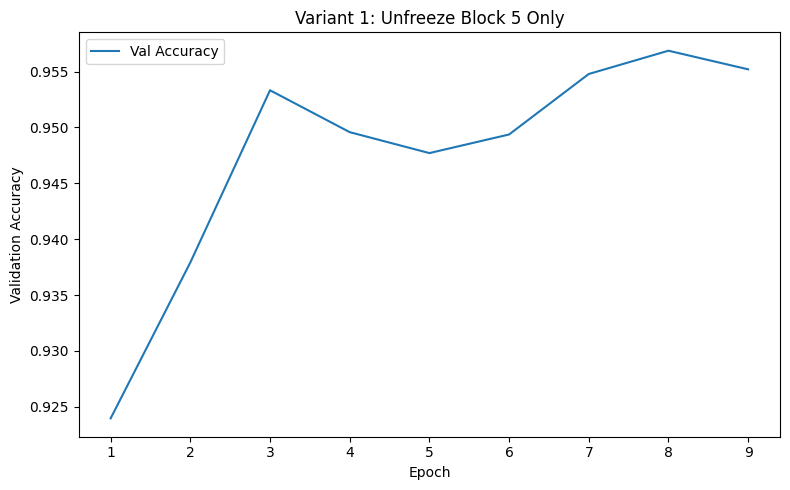

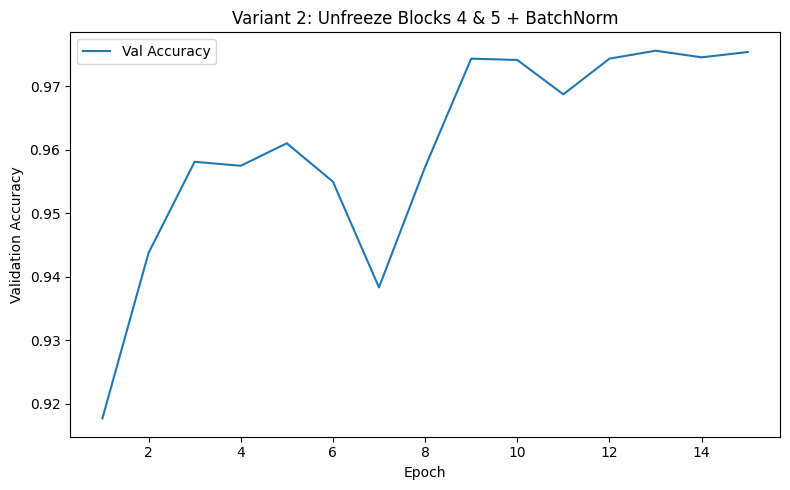

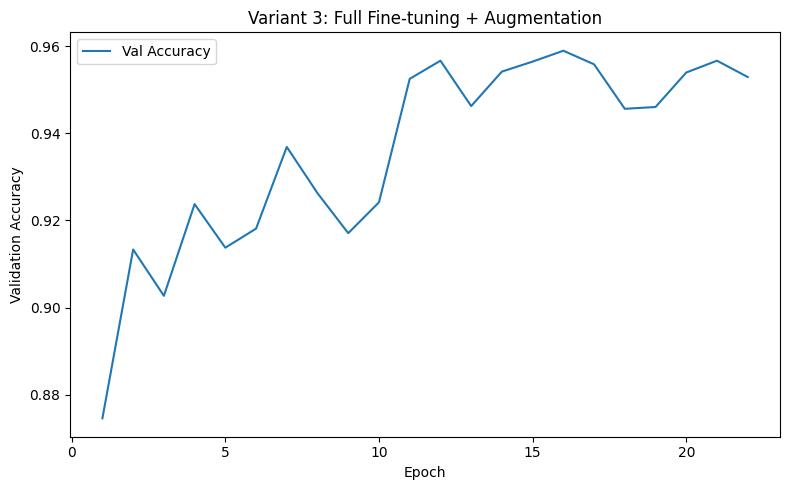

In [ ]:
histories = [history1, history2, history3]
titles = [
    "Variant 1: Unfreeze Block 5 Only",
    "Variant 2: Unfreeze Blocks 4 & 5 + BatchNorm",
    "Variant 3: Full Fine‐tuning + Augmentation"
]
for hist, title in zip(histories, titles):
    epochs = range(1, len(hist.history['val_accuracy']) + 1)
    val_acc = hist.history['val_accuracy']

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report

p1 = model1.predict(valX, batch_size=64, verbose=1)
p2 = model2.predict(valX, batch_size=64, verbose=1)
p3 = model3.predict(valX, batch_size=64, verbose=1)

c1 = np.argmax(p1, axis=1)
c2 = np.argmax(p2, axis=1)
c3 = np.argmax(p3, axis=1)

stacked = np.vstack([c1, c2, c3])
ensemble_preds, _ = mode(stacked, axis=0)
ensemble_preds = ensemble_preds.ravel()

ensemble_acc = accuracy_score(valY, ensemble_preds)
print(f"Ensemble Accuracy: {ensemble_acc:.4f}\n")
print(classification_report(valY, ensemble_preds))

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
Ensemble Accuracy: 0.9735

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       600
           1       0.97      0.99      0.98       600
           2       0.97      0.96      0.96       600
           3       0.96      0.96      0.96       500
           4       0.99      0.99      0.99       500
           5       0.97      0.97      0.97       400
           6       0.97      0.95      0.96       500
           7       0.98      0.99      0.99       600
           8       0.98      0.96      0.97       500

    accuracy                           0.97      4800
   macro avg       0.97      0.97      0.97      4800
weighted avg       0.97      0.97      0.97      4800

